In [1]:
from icecube import dataio,dataclasses
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")

from lib.geo import get_xyz_from_zenith_azimuth
from lib.geo import __theta_cherenkov
__theta_cherenkov_deg = np.rad2deg(__theta_cherenkov)
print(__theta_cherenkov_deg)

40.134791222536876


In [2]:
f = dataio.I3File('/home/storage/hans/jax_reco_new/extract_data_from_i3files/test.i3.zst')
g = dataio.I3File('/home/storage2/hans/i3files/GeoCalibDetectorStatus_2020.Run134142.Pass2_V0.i3.gz')
g_frame = g.pop_frame()
geo = g_frame['I3Geometry'].omgeo

(0.001, 1000)

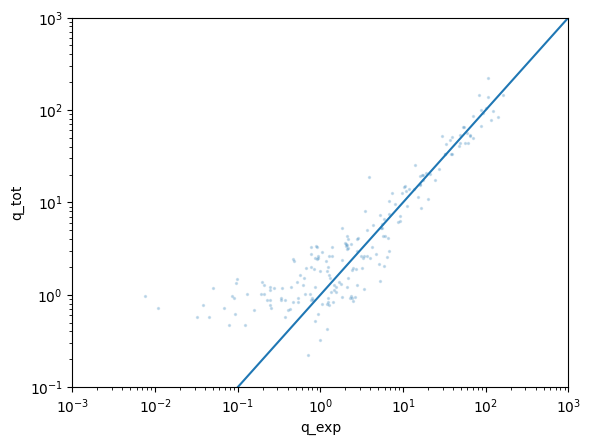

In [3]:
frame = f.pop_physics()
expq_dict = frame['MCMostEnergeticTrack_I3MCTree_ExQ']
obsq_dict = dict()
min_time_dict = dict()

pmap = dataclasses.I3RecoPulseSeriesMap.from_frame(frame, "TWSRTHVInIcePulsesIC")
for om, pulses in pmap.items():
    obsq_dict[om] = np.sum([p.charge for p in pulses])
    min_time_dict[om] = np.min([[p.time for p in pulses]])


qexp_list = []
qtot_list = []
#for key in pmap.keys():
    #qtot = sum([p.charge for p in pulses[key]])

for key, qtot in obsq_dict.items():
    qexp = sum(expq_dict[key])
    qexp_list.append(qexp)
    qtot_list.append(qtot)


fig, ax = plt.subplots()
plt.scatter(qexp_list, qtot_list, s=2, alpha=0.2)
plt.plot([0.001, 1000], [0.001, 1000])
plt.xlabel('q_exp')
plt.ylabel('q_tot')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 10**3])
plt.xlim([0.001, 10**3])

In [4]:
I3MCTree = frame['I3MCTree']

loss_pos = []
for p in I3MCTree.get_daughters(I3MCTree[0]):
     for loss in I3MCTree.get_daughters(p):
           if not 'Mu' in str(loss.type):
                pos = loss.pos
                loss_pos.append([pos.x, pos.y, pos.z])

loss_pos = jnp.array(loss_pos)
print(loss_pos.shape)

dom_pos = []
q_exp = []
q_tot = []
t_obs = []
for key in obsq_dict.keys():
    pos = geo[key].position
    dom_pos.append([pos.x, pos.y, pos.z])
    q_exp.append(expq_dict[key])
    q_tot.append(obsq_dict[key])
    t_obs.append(min_time_dict[key])

q_exp = jnp.array(q_exp)
dom_pos = jnp.array(dom_pos)
q_tot = jnp.array(q_tot)
t_obs = jnp.array(t_obs)
print(dom_pos.shape)
print(q_exp.shape)
print(q_tot.shape)

mctruth = frame['MCMostEnergeticTrack']
track_dir_xyz = get_xyz_from_zenith_azimuth([mctruth.dir.zenith, mctruth.dir.azimuth])
track_pos = jnp.array([mctruth.pos.x, mctruth.pos.y, mctruth.pos.z])

(345, 3)
(201, 3)
(201, 345)
(201,)


In [5]:
print(np.sum(q_tot))

2954.874999910593


In [6]:
def get_charge_network_eval_fn(bpath: str = '../../data/network/', n_layer=7, dtype=jnp.float64):
    """
    """
    params = []

    for i in range(0, n_layer):
        layer_weights = np.load(os.path.join(bpath, f'dense_{i}_weights.npy'))
        layer_bias = np.load(os.path.join(bpath, f'dense_{i}_bias.npy'))
        params.append((
                        jnp.array(layer_weights, dtype=dtype),
                        jnp.array(layer_bias, dtype=dtype)
                    ))

    params = tuple(params)

    def eval_network(x):
        """
        """

        x = jnp.tanh(jnp.dot(x, params[0][0]) + params[0][1])

        # residual block 1
        y = jnp.tanh(jnp.dot(x, params[1][0]) + params[1][1])
        x = jnp.tanh(jnp.dot(y, params[2][0]) + params[2][1]) + x

        # residual block 2
        y = jnp.tanh(jnp.dot(x, params[3][0]) + params[3][1])
        x = jnp.tanh(jnp.dot(y, params[4][0]) + params[4][1]) + x

        # outputs
        y = jnp.tanh(jnp.dot(x, params[5][0]) + params[5][1])
        z = jnp.dot(y, params[6][0]) + params[6][1]

        return z

    return eval_network


def get_charge_network_eval_v_fn(bpath: str = '../../data/network/', n_layer=9, dtype=jnp.float64):
    """
    """
    eval_network = get_charge_network_eval_fn(bpath = bpath, n_layer=n_layer, dtype=dtype)
    eval_network_v = jax.jit(jax.vmap(eval_network, 0, 0))
    return eval_network_v

In [7]:
eval_charge = get_charge_network_eval_v_fn(bpath='/home/storage/hans/photondata/amplitude_fractions/code/network/tmp2/extract/', n_layer=7)

In [8]:
from lib.geo import cherenkov_cylinder_coordinates_w_rho_v
from lib.trafos import transform_network_inputs_v

In [9]:
geo_time, closest_approach_dist, closest_approach_z, closest_approach_rho = \
            cherenkov_cylinder_coordinates_w_rho_v(dom_pos,
                                         track_pos,
                                         track_dir_xyz)

track_zenith = mctruth.dir.zenith 
track_azimuth = mctruth.dir.azimuth
x = jnp.column_stack([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          jnp.repeat(track_zenith, len(closest_approach_dist)),
                          jnp.repeat(track_azimuth, len(closest_approach_dist))])

In [10]:
x = jnp.array(x, dtype=jnp.float32)

x_prime = transform_network_inputs_v(x)
y_pred = jnp.exp(eval_charge(x_prime))

In [11]:
rescale = jnp.sum(q_tot) / jnp.sum(y_pred) 
print(rescale)

69.41063504641497


In [12]:
y_pred_rescaled = rescale * y_pred

(0.1, 1000)

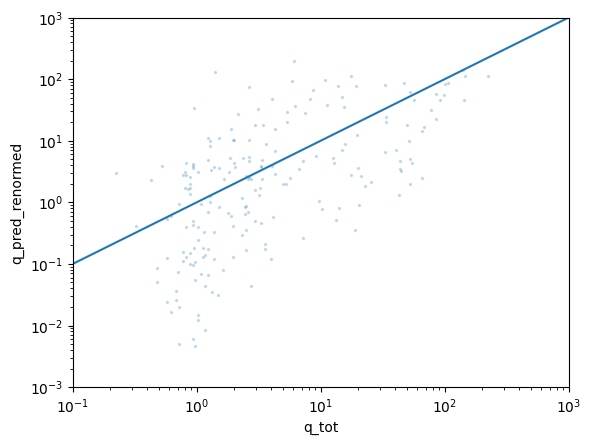

In [13]:
q_tot = jnp.array(q_tot)

fig, ax = plt.subplots()
plt.scatter(q_tot, y_pred_rescaled, s=2, alpha=0.2)
plt.plot([0.001, 1000], [0.001, 1000])
plt.xlabel('q_tot')
plt.ylabel('q_pred_renormed')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.001, 10**3])
plt.xlim([0.1, 10**3])

In [14]:
print(jnp.min(closest_approach_dist))

20.898940578810816


In [15]:
delay_time = t_obs - (geo_time + mctruth.time)

In [16]:
idx = jnp.squeeze(y_pred_rescaled < 0.01)
print(delay_time[idx])

[-313.98045472 -668.43825695 2001.66013541 1873.67968622 1686.70004501]


In [ ]:
q_pred = 